#### We create a lightgbm model to classify the bookingID
#### We select the best features using the feature selector library created by WillKoehrsen 
#### https://github.com/WillKoehrsen/feature-selector

### Please make sure that you have the "feature_selector "folder and also "modeling_toolbox.py" in this training folder

#### Search for hyper parameters is done with hyperopt
#### Cross validation is done with the best hyper parameters found by hyperopt
#### If we are happy with the model, we train it on the all training dataset and save it for prediction in the folder "./prediction/models/"

In [1]:
## coding=utf-8
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from collections import Counter
from hyperopt import Trials, hp, tpe
from hyperopt.fmin import fmin
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.externals import joblib

from feature_selector import FeatureSelector
from modeling_toolbox import run_cross_validation, plot_imp_model, model_evaluation, estimate_benefit

pd.set_option('display.width', 3000)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 210)

### Import Training Set

In [2]:
df = pd.read_parquet('../data/3-ml_datasets/df_xgb_train.parquet')
df.head()

,bookingID,Accuracy_count,Accuracy_mean,Accuracy_std,Accuracy_sum,Accuracy_min,Accuracy_median,Accuracy_max,Bearing_count,Bearing_mean,Bearing_std,Bearing_sum,Bearing_min,Bearing_median,Bearing_max,acceleration_x_count,acceleration_x_mean,acceleration_x_std,acceleration_x_sum,acceleration_x_min,acceleration_x_median,acceleration_x_max,acceleration_y_count,acceleration_y_mean,acceleration_y_std,acceleration_y_sum,acceleration_y_min,acceleration_y_median,acceleration_y_max,acceleration_z_count,acceleration_z_mean,acceleration_z_std,acceleration_z_sum,acceleration_z_min,acceleration_z_median,acceleration_z_max,gyro_x_count,gyro_x_mean,gyro_x_std,gyro_x_sum,gyro_x_min,gyro_x_median,gyro_x_max,gyro_y_count,gyro_y_mean,gyro_y_std,gyro_y_sum,gyro_y_min,gyro_y_median,gyro_y_max,gyro_z_count,gyro_z_mean,gyro_z_std,gyro_z_sum,gyro_z_min,gyro_z_median,gyro_z_max,Speed_count,Speed_mean,Speed_std,Speed_sum,Speed_min,Speed_median,Speed_max,harsh_acceleration_x_count,harsh_acceleration_x_mean,harsh_acceleration_x_std,harsh_acceleration_x_sum,harsh_acceleration_x_min,harsh_acceleration_x_median,harsh_acceleration_x_max,harsh_acceleration_y_count,harsh_acceleration_y_mean,harsh_acceleration_y_std,harsh_acceleration_y_sum,harsh_acceleration_y_min,harsh_acceleration_y_median,harsh_acceleration_y_max,harsh_acceleration_z_count,harsh_acceleration_z_mean,harsh_acceleration_z_std,harsh_acceleration_z_sum,harsh_acceleration_z_min,harsh_acceleration_z_median,harsh_acceleration_z_max,d_gyro_x-1_count,d_gyro_x-1_mean,d_gyro_x-1_std,d_gyro_x-1_sum,d_gyro_x-1_min,d_gyro_x-1_median,d_gyro_x-1_max,d_gyro_x-2_count,d_gyro_x-2_mean,d_gyro_x-2_std,d_gyro_x-2_sum,d_gyro_x-2_min,d_gyro_x-2_median,d_gyro_x-2_max,d_gyro_x-3_count,d_gyro_x-3_mean,d_gyro_x-3_std,d_gyro_x-3_sum,d_gyro_x-3_min,d_gyro_x-3_median,...,"gyro_z__fft_coefficient__coeff_88__attr_""angle""","gyro_z__fft_coefficient__coeff_88__attr_""imag""","gyro_z__fft_coefficient__coeff_88__attr_""real""","gyro_z__fft_coefficient__coeff_89__attr_""abs""","gyro_z__fft_coefficient__coeff_89__attr_""angle""","gyro_z__fft_coefficient__coeff_89__attr_""imag""","gyro_z__fft_coefficient__coeff_89__attr_""real""","gyro_z__fft_coefficient__coeff_8__attr_""abs""","gyro_z__fft_coefficient__coeff_8__attr_""angle""","gyro_z__fft_coefficient__coeff_8__attr_""imag""","gyro_z__fft_coefficient__coeff_8__attr_""real""","gyro_z__fft_coefficient__coeff_90__attr_""abs""","gyro_z__fft_coefficient__coeff_90__attr_""angle""","gyro_z__fft_coefficient__coeff_90__attr_""imag""","gyro_z__fft_coefficient__coeff_90__attr_""real""","gyro_z__fft_coefficient__coeff_91__attr_""abs""","gyro_z__fft_coefficient__coeff_91__attr_""angle""","gyro_z__fft_coefficient__coeff_91__attr_""imag""","gyro_z__fft_coefficient__coeff_91__attr_""real""","gyro_z__fft_coefficient__coeff_92__attr_""abs""","gyro_z__fft_coefficient__coeff_92__attr_""angle""","gyro_z__fft_coefficient__coeff_92__attr_""imag""","gyro_z__fft_coefficient__coeff_92__attr_""real""","gyro_z__fft_coefficient__coeff_93__attr_""abs""","gyro_z__fft_coefficient__coeff_93__attr_""angle""","gyro_z__fft_coefficient__coeff_93__attr_""imag""","gyro_z__fft_coefficient__coeff_93__attr_""real""","gyro_z__fft_coefficient__coeff_94__attr_""abs""","gyro_z__fft_coefficient__coeff_94__attr_""angle""","gyro_z__fft_coefficient__coeff_94__attr_""imag""","gyro_z__fft_coefficient__coeff_94__attr_""real""","gyro_z__fft_coefficient__coeff_95__attr_""abs""","gyro_z__fft_coefficient__coeff_95__attr_""angle""","gyro_z__fft_coefficient__coeff_95__attr_""imag""","gyro_z__fft_coefficient__coeff_95__attr_""real""","gyro_z__fft_coefficient__coeff_96__attr_""abs""","gyro_z__fft_coefficient__coeff_96__attr_""angle""","gyro_z__fft_coefficient__coeff_96__attr_""imag""","gyro_z__fft_coefficient__coeff_96__attr_""real""","gyro_z__fft_coefficient__coeff_97__attr_""abs""","gyro_z__fft_coefficient__coeff_97__attr_""angle""","gyro_z__fft_coefficient__coeff_97__attr_""imag""","gyro_z__fft_coefficient__coeff_97__attr_""real""","gyro

In [3]:
id_col = 'bookingID'
target_variable = 'label'
feature_cols = [col for col in df.columns]
feature_cols.remove(id_col)
feature_cols.remove(target_variable)

#### Do the feature selection

(16000, 7359)
544 features will be dropped because they contain only one unique value.
Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid_0's auc: 0.71083	valid_0's binary_logloss: 0.506485
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's auc: 0.731225	valid_0's binary_logloss: 0.489396
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[65]	valid_0's auc: 0.739818	valid_0's binary_logloss: 0.486663
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[132]	valid_0's auc: 0.746376	valid_0's binary_logloss: 0.463114
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's auc: 0.743339	valid_0's binary_logloss: 0.478445
Training until validation scores don't improve for 100 rounds.
Early 

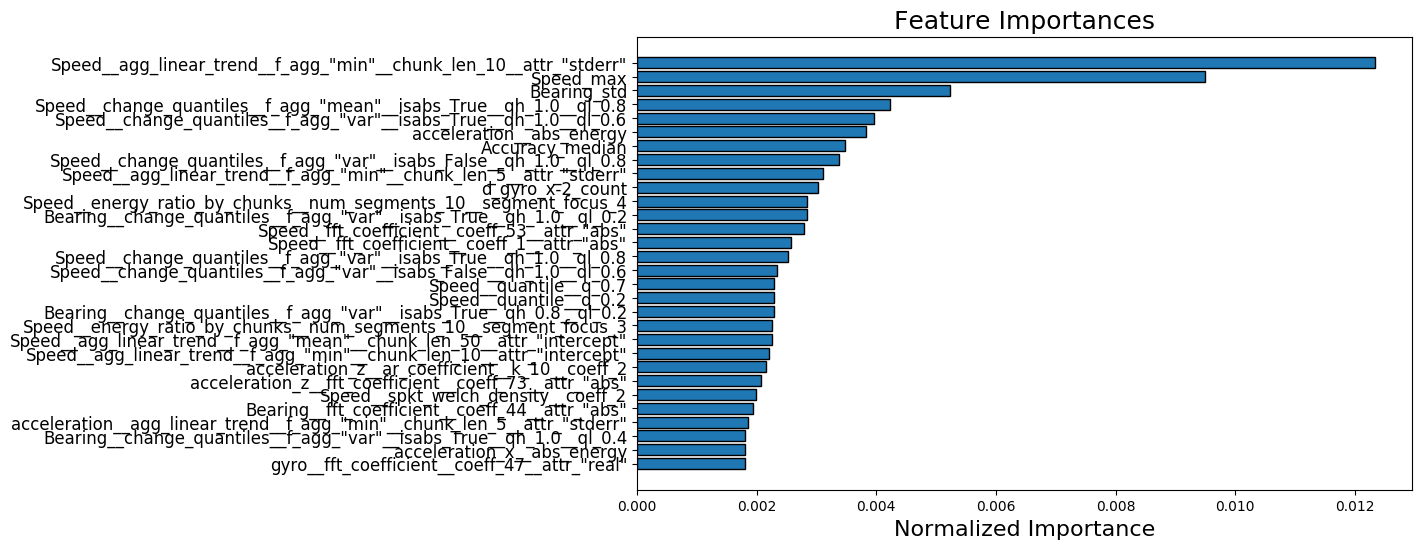

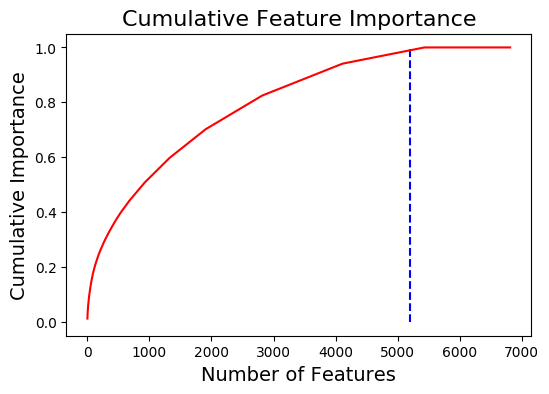

5200 features required for 0.99 of cumulative importance


In [5]:
df_train = df.copy()

print(df_train.shape)

feature_cols_filter = list(feature_cols)
#Remove columns with unique value
unique_values = df_train.nunique().reset_index()
unique_values.columns = ['FEATURE_NAME','NB_UNIQUE_VALUE']
unique_values = list(unique_values.loc[unique_values.NB_UNIQUE_VALUE==1,'FEATURE_NAME'])
print("%i features will be dropped because they contain only one unique value."  %len(unique_values))
df_train = df_train.drop(unique_values, axis=1)
for col in unique_values:
    if col in feature_cols_filter:
        feature_cols_filter.remove(col)

#Drop zero importance features using FeatureSelector
train_labels = df_train[target_variable].copy()
train = df_train[feature_cols_filter].copy()
fs = FeatureSelector(data = train, labels = train_labels)
fs.identify_zero_importance(task = 'classification', eval_metric = 'auc', n_iterations = 10, early_stopping = True)
zero_importance_features = fs.ops['zero_importance']
print("%i features will be dropped because zero importance."  %len(zero_importance_features))
df_train = df_train.drop(zero_importance_features, axis=1)
for col in zero_importance_features:
    if col in feature_cols_filter:
        feature_cols_filter.remove(col)
        
#Drop low importance features using FS
fs.identify_low_importance(cumulative_importance = 0.99)
low_importance_features = fs.ops['low_importance']
print("%i features will be dropped because low importance."  %len(low_importance_features))
for col in low_importance_features:
    if col in df_train.columns:
        df_train = df_train.drop(col, axis=1)
    if col in feature_cols_filter:
        feature_cols_filter.remove(col)
        
print(df_train.shape)
fs.plot_feature_importances(threshold = 0.99, plot_n = 30)

#### We save the selected features for the prediction part

In [7]:
print('Saving features for lgbm...')
joblib.dump(feature_cols_filter,'../02_prediction/models/feature_cols_lgb_model.pkl')

Saving features for lgbm...


['../02_prediction/models/feature_cols_lgb_model.pkl']

#### Find best Hyper Parameters using hyperopt
#### Best parameters have already been found and put in the next section, so it is not necessary to run again the search

In [9]:
def objective(params):
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_split_gain': "{:.3f}".format(params['min_split_gain']),
        'colsample_bytree': "{:.3f}".format(params['colsample_bytree']),
        'subsample': "{:.3f}".format(params['subsample']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']), 
        'reg_lambda': "{:.3f}".format(params['reg_lambda'])
    }
    
    gss = GroupShuffleSplit(n_splits=4,test_size=0.25,random_state=0)
    X_cv = df_train[feature_cols_filter].copy()
    y_cv = df_train[target_variable].copy()
    groups = df_train[id_col].copy()
    
    clf = lgb.LGBMClassifier(base_score=y_cv.mean(),n_jobs=7,**params)
    
    #run tuned CV
    cv = gss.split(X_cv, y_cv, groups)
    score = cross_val_score(clf, X_cv, y_cv, scoring='neg_log_loss', cv=cv, n_jobs=2).mean()
    #print("LOG LOSS: {:.3f} params {}".format(-score, params))
    return -score

space = {
    'n_estimators': hp.quniform('n_estimators', 100, 400, 10),
    'max_depth': hp.quniform('max_depth', 4, 8, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0.0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.9),
    'subsample':hp.uniform('subsample', 0.8, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.03, 0.05),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),

}

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials = trials,
            max_evals=20)
print("Best score is :{:.5f} \nWith Hyperopt estimated optimum {}".format(trials.best_trial['result']['loss'],best))

results_gs = pd.concat([pd.DataFrame(trials.results), pd.DataFrame(trials.idxs_vals[1])], axis=1)
results_gs = results_gs.sort_values(by='loss').reset_index(drop=True)
results_gs

  5%|▌         | 1/20 [06:33<2:04:38, 393.63s/it, best loss: 0.4950134863894647]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 10%|█         | 2/20 [10:54<1:46:08, 353.82s/it, best loss: 0.4872319580448344]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-use

 15%|█▌        | 3/20 [13:31<1:23:29, 294.66s/it, best loss: 0.4872319580448344]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 35%|███▌      | 7/20 [41:13<1:30:24, 417.27s/it, best loss: 0.4862208962386765] 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 50%|█████     | 10/20 [55:38<55:34, 333.45s/it, best loss: 0.4862208962386765] 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 55%|█████▌    | 11/20 [1:01:21<50:28, 336.51s/it, best loss: 0.4862208962386765]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 70%|███████   | 14/20 [1:19:42<33:53, 338.95s/it, best loss: 0.4862208962386765]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 75%|███████▌  | 15/20 [1:23:12<25:01, 300.21s/it, best loss: 0.4862208962386765]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 80%|████████  | 16/20 [1:34:51<28:00, 420.04s/it, best loss: 0.4862208962386765]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-use

 90%|█████████ | 18/20 [1:47:58<13:36, 408.28s/it, best loss: 0.4862208962386765]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-use

 95%|█████████▌| 19/20 [1:50:43<05:35, 335.11s/it, best loss: 0.4862208962386765]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



100%|██████████| 20/20 [1:56:16<00:00, 334.74s/it, best loss: 0.4862208962386765]
Best score is :0.48622 
With Hyperopt estimated optimum {'colsample_bytree': 0.8410298278053778, 'learning_rate': 0.030324609360946362, 'max_depth': 8.0, 'min_split_gain': 0.19256634236808196, 'n_estimators': 210.0, 'reg_alpha': 0.12936486682188053, 'reg_lambda': 0.5461168017853416, 'subsample': 0.8130081701144499}


,loss,status,colsample_bytree,learning_rate,max_depth,min_split_gain,n_estimators,reg_alpha,reg_lambda,subsample
0,0.486221,ok,0.841030,0.030325,8.0,0.192566,210.0,0.129365,0.546117,0.813008
1,0.486477,ok,0.748457,0.039278,4.0,0.432273,160.0,0.736014,0.662968,0.805568
2,0.486555,ok,0.837166,0.031420,5.0,0.313841,230.0,0.282763,0.524587,0.989407
3,0.486936,ok,0.731126,0.041784,6.0,0.198083,140.0,0.844882,0.292147,0.919658
4,0.487044,ok,0.778503,0.034455,6.0,0.346810,190.0,0.238901,0.955791,0.889823
5,0.487055,ok,0.724398,0.037229,6.0,0.406913,170.0,0.551804,0.763254,0.920899
6,0.487204,ok,0.613434,0.035547,6.0,0.242197,180.0,0.380096,0.646648,0.937878
7,0.487232,ok,0.794582,0.039345,7.0,0.405443,130.0,0.730276,0.683241,0.919143
8,0.487545,ok,0.824839,0.045591,4.0,0.267903,130.0,0.334251,0.173332,0.922050
9,0.487864,ok,0.641935,0.034171,7.0,0.081887,110.0,0.278909,0.583206,0.907330


#### Assess performance with Cross Validation

In [8]:
# We comment this section if you just want to retrain the model and not run again hyperopt

# clf_params = {
#     'n_estimators': int(best['n_estimators']),
#     'max_depth': int(best['max_depth']),
#     'min_split_gain': "{:.3f}".format(best['min_split_gain']),
#     'colsample_bytree': "{:.3f}".format(best['colsample_bytree']),
#     'subsample':"{:.3f}".format(best['subsample']),
#     'learning_rate': "{:.3f}".format(best['learning_rate']),
#     'reg_alpha': "{:.3f}".format(best['reg_alpha']),
#     'reg_lambda': "{:.3f}".format(best['reg_lambda']),
#     'base_score': df_train[target_variable].mean()
#     }

# For convinience we put here the hyper parameters found by hyperopt
clf_params = {'colsample_bytree': 0.841, 
             'min_split_gain': 0.192, 
             'learning_rate': 0.03, 
             'max_depth': 8, 
             'n_estimators': 210, 
             'reg_alpha': 0.129, 
             'reg_lambda': 0.546, 
             'subsample': 0.813}

cross validation started
shuffle: 0, AUC: 0.744734, lift at 10 percent: 2.532787
shuffle: 1, AUC: 0.740915, lift at 10 percent: 2.594777
shuffle: 2, AUC: 0.733377, lift at 10 percent: 2.694561
shuffle: 3, AUC: 0.721417, lift at 10 percent: 2.459150
shuffle: 4, AUC: 0.734864, lift at 10 percent: 2.466330
shuffle: 5, AUC: 0.737453, lift at 10 percent: 2.546064
shuffle: 6, AUC: 0.740877, lift at 10 percent: 2.550167
shuffle: 7, AUC: 0.746615, lift at 10 percent: 2.547560
shuffle: 8, AUC: 0.731132, lift at 10 percent: 2.438193
shuffle: 9, AUC: 0.737752, lift at 10 percent: 2.487884


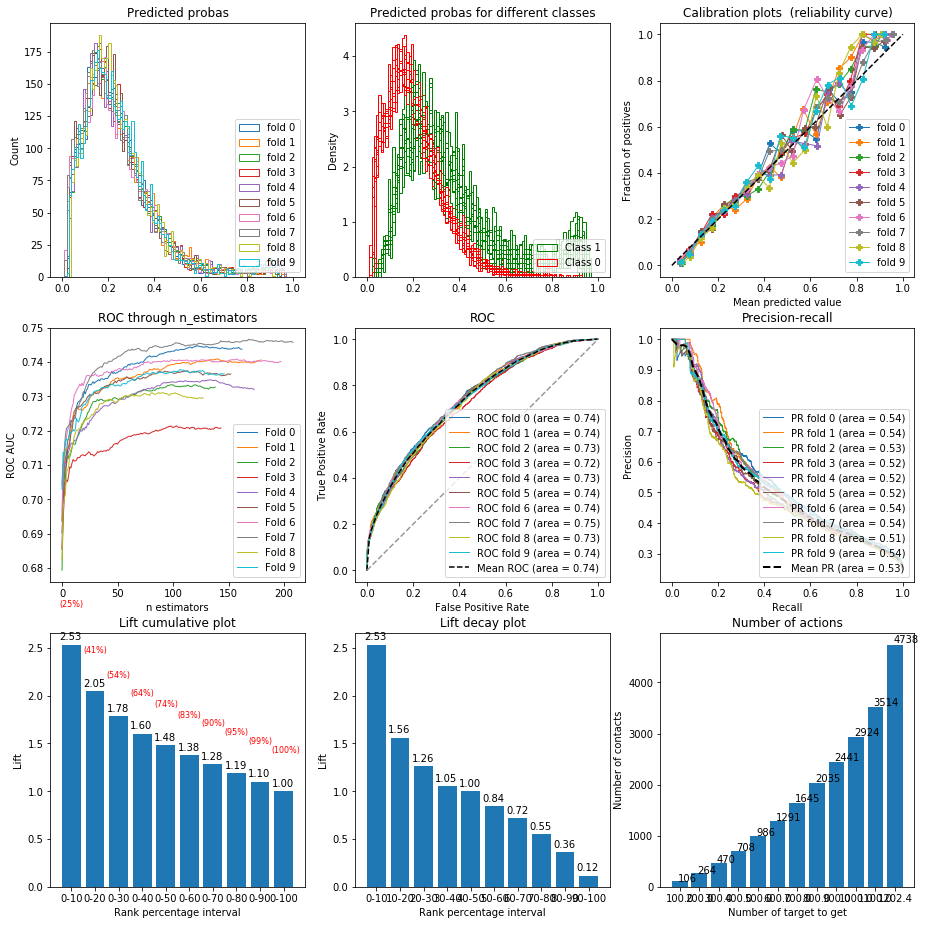

<Figure size 432x288 with 0 Axes>

In [6]:
clf = lgb.LGBMClassifier(n_jobs=10,**clf_params)

cv_result = run_cross_validation(df_train, clf, feature_cols_filter, id_col, target_variable, 'prob_1', _n_iter=10)


### If we are happy, we train a model using hyperopt parameters on the whole training dataset and save the model in '../prediction/models/'

In [5]:
#feature_cols_filter
#feature_cols_filter = joblib.load('../02_prediction/models/feature_cols_lgb_model.pkl')
#df_train = df.copy()

In [9]:
X_train = df_train[feature_cols_filter].copy()
y_train = df_train[target_variable].copy()

clf = lgb.LGBMClassifier(n_jobs=10,**clf_params)
clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric='logloss', verbose=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.841, importance_type='split',
        learning_rate=0.03, max_depth=8, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.192, n_estimators=210,
        n_jobs=10, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.129, reg_lambda=0.546, silent=True, subsample=0.813,
        subsample_for_bin=200000, subsample_freq=0)

In [10]:
print('Saving model...')
# save model to file
clf.booster_.save_model('../02_prediction/models/lgb_model.txt')
joblib.dump(clf,'../02_prediction/models/lgb_model.pkl')

Saving model...


['../02_prediction/models/lgb_model.pkl']

#### Check Feature importances

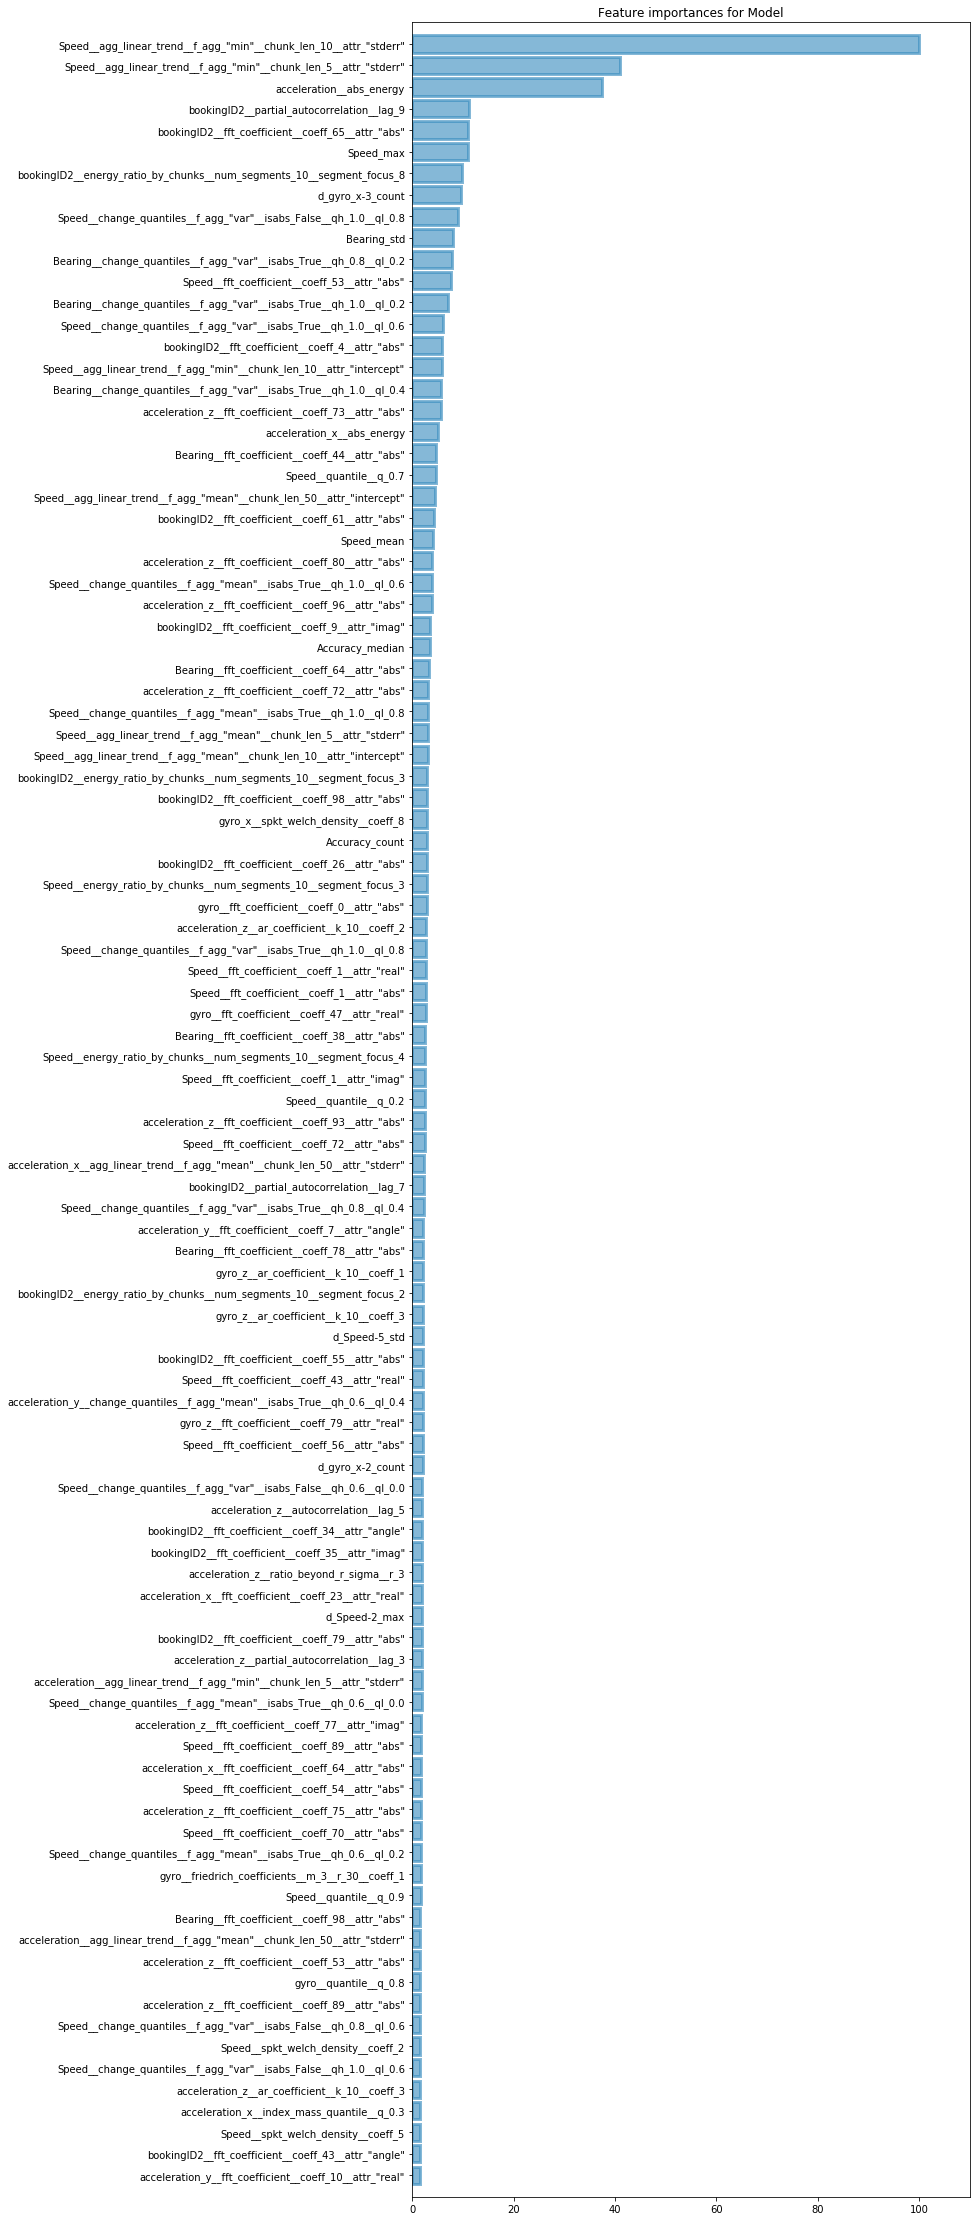

In [11]:
feature_importances = plot_imp_model(clf, top_n=100, weight='gain')